In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import warnings

S&P 500 Dataset:
         Date        Close
0  2013-01-02  1462.420044
1  2013-01-03  1459.369995
2  2013-01-04  1466.469971
3  2013-01-07  1461.890015
4  2013-01-08  1457.150024

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2518 non-null   object 
 1   Close   2518 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.5+ KB
None

Summary Statistics:
count    2518.000000
mean     2742.695377
std       872.793493
min      1457.150024
25%      2050.752441
50%      2584.900024
75%      3275.690002
max      4796.560059
Name: Close, dtype: float64

Missing values in each column:
Date     0
Close    0
dtype: int64


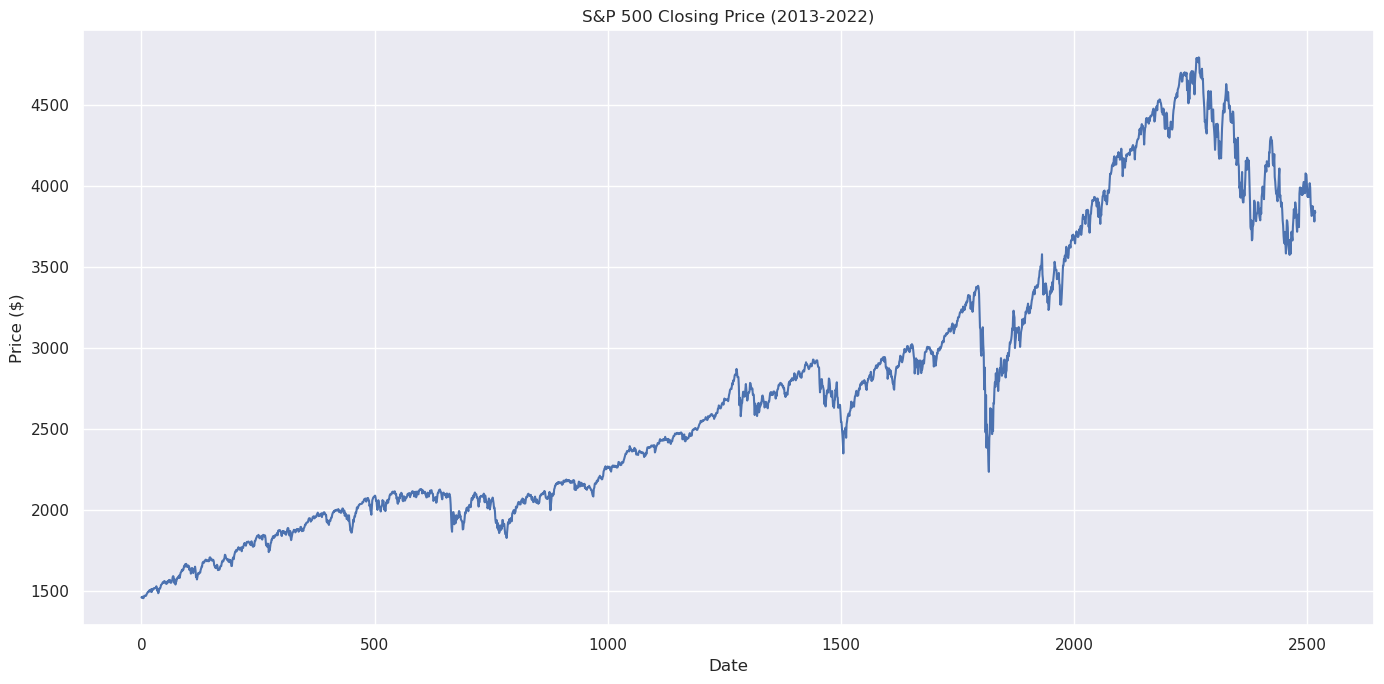


Selected time series shape: (2518,)


In [4]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_theme()

# Download S&P 500 data for the last 10 years
# sp500 = yf.download('^GSPC', start='2013-01-01', end='2022-12-31')
sp500 = pd.read_csv("sp500.csv")

# Display the first few rows of the dataset
print("S&P 500 Dataset:")
print(sp500.head())

# Display basic information about the dataset
print("\nDataset information:")
print(sp500.info())

# Calculate basic summary statistics
print("\nSummary Statistics:")
print(sp500['Close'].describe())

# Check for missing values
print("\nMissing values in each column:")
print(sp500.isnull().sum())

# Plot the closing price
plt.figure(figsize=(14, 7))
plt.plot(sp500.index, sp500['Close'])
plt.title('S&P 500 Closing Price (2013-2022)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Select the closing price as our primary time series for analysis
ts_data = sp500['Close']
print("\nSelected time series shape:", ts_data.shape)

In [18]:
# Test original data
result = adfuller(ts_data.dropna())
print("p-value:", result[1])

# Transform if non-stationary
ts_log = np.log(ts_data)
ts_log = ts_log.set_axis(sp500['Date'])
ts_log_diff = ts_log.diff(periods=1).dropna()

p-value: 0.7417120357643823


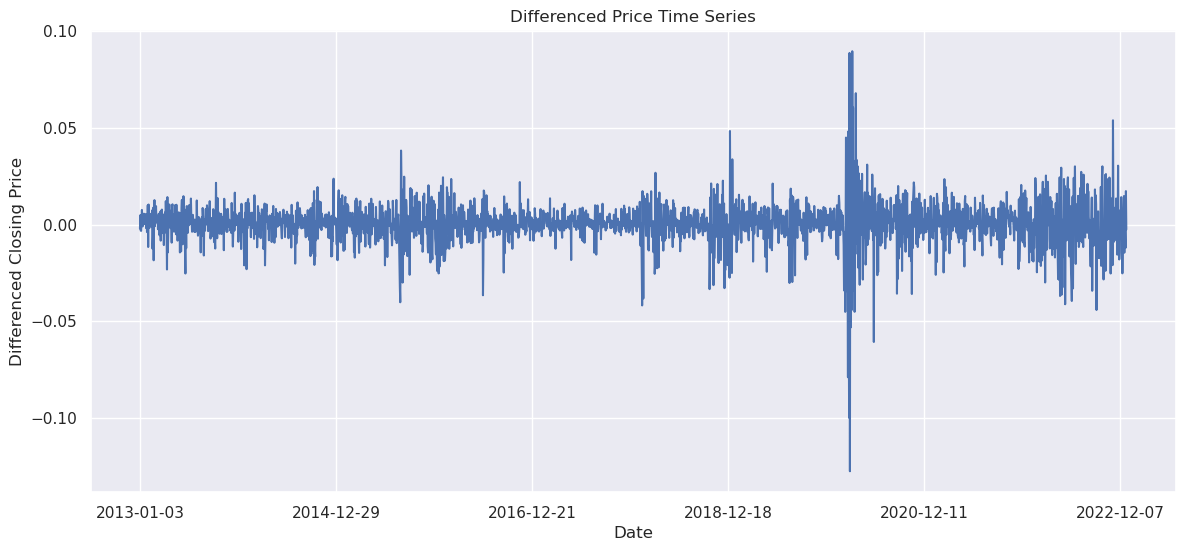

In [21]:
ts_log_diff.plot(figsize=(14, 6))
plt.xlabel("Date")
plt.ylabel("Differenced Closing Price")
plt.title("Differenced Price Time Series")
plt.show()

In [49]:
ts_log_df = ts_log_diff.to_frame().reset_index()
ts_log_df['Date'] = pd.to_datetime(ts_log_df['Date'])
ts_log_df.set_index('Date', inplace=True)

ts_monthly_mean = ts_log_df['Close'].resample('MS').mean()
ts_cleaned = ts_monthly_mean.bfill()


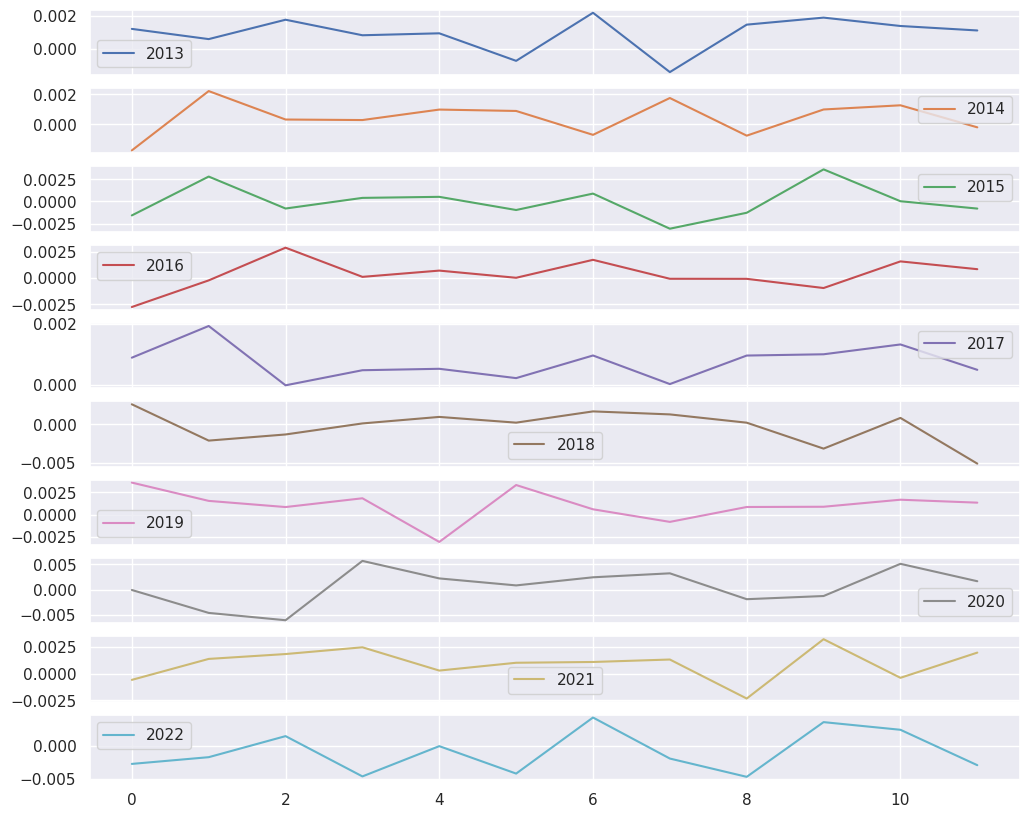

In [50]:
year_groups = ts_cleaned.groupby(pd.Grouper(freq='A'))

ts_annual = pd.DataFrame()

for yr, group in year_groups:
    ts_annual[yr.year] = group.values.ravel()

ts_annual.plot(figsize=(12,10), subplots=True, legend=True)
plt.show()

There may be a slight spike toward the end of the year but it is inconsistent. There does not seem to be annual trends.

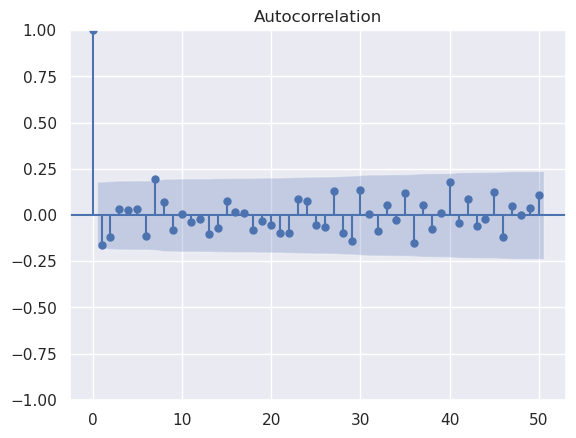

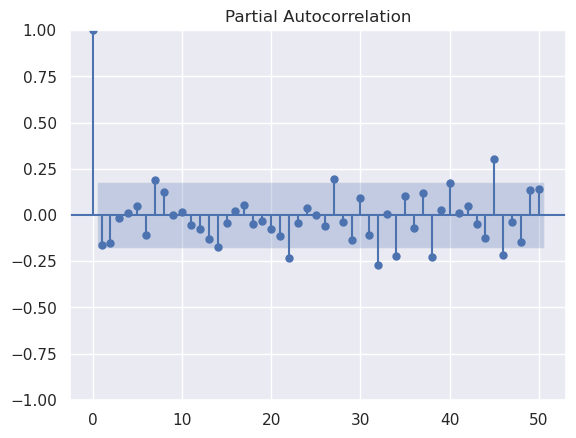

In [53]:
plot_acf(ts_cleaned, lags=50)
plt.show()

plot_pacf(ts_cleaned, lags=50)
plt.show()

In [55]:
# ARIMA model

# Make training and test sets
train_size = int(len(ts_cleaned) * 0.8)
train, test = ts_cleaned[0:train_size], ts_cleaned[train_size:len(ts_cleaned)]

#Define and fit model
model = ARIMA(ts_cleaned, order=(2, 1, 2))
model_fit = model.fit()

# Print the model summary
aic = model_fit.aic
bic = model_fit.bic

round(aic, 1), round(bic, 1)

(-1124.3, -1110.4)

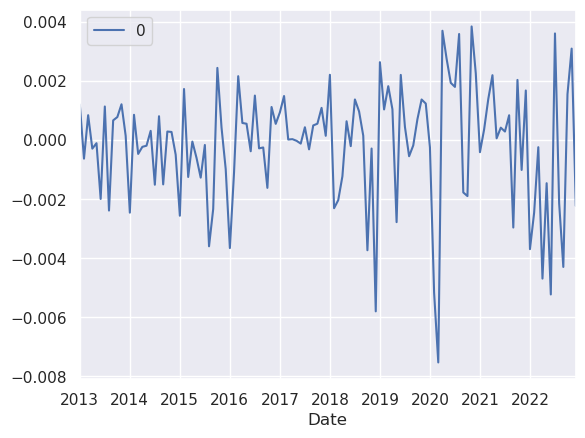

In [56]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()